# **Twitter Sentiment Classifier**

### **Overview**

This is an entity-level sentiment analysis dataset of twitter. Given a message and an entity, the task is to judge the sentiment of the message about the entity. There are three classes in this dataset: Positive, Negative and Neutral. We regard messages that are not relevant to the entity (i.e. Irrelevant) as Neutral.

## Import Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import precision_score, recall_score, roc_curve, accuracy_score,confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Binarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [3]:
from wordcloud import WordCloud
import string
import re
import joblib 
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## **Import Data**

In [4]:
import warnings
warnings.filterwarnings('ignore')


df = pd.read_csv(r'C:\Users\Dell\Sentimental-Analysis\data\twitter_training.csv')
test = pd.read_csv(r'C:\Users\Dell\Sentimental-Analysis\data\twitter_validation.csv')

/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv
/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv
/kaggle/input/twitter-airline-sentiment/Tweets.csv
/kaggle/input/twitter-airline-sentiment/database.sqlite


## **Data Cleaning**

#### **Rename Columns**

In [6]:
df.rename(columns={list(df)[0]:'TweetID',
                   list(df)[1]:'Entity',
                      list(df)[2]:'Sentiment',
                      list(df)[3]:'Tweet'},inplace=True)
df.head(3)

,TweetID,Entity,Sentiment,Tweet
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74681 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   TweetID    74681 non-null  int64 
 1   Entity     74681 non-null  object
 2   Sentiment  74681 non-null  object
 3   Tweet      73995 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


#### **Drop Column**

In [8]:
df = df.drop(columns='TweetID')

In [9]:
df.isnull().sum()

Entity         0
Sentiment      0
Tweet        686
dtype: int64

<Axes: >

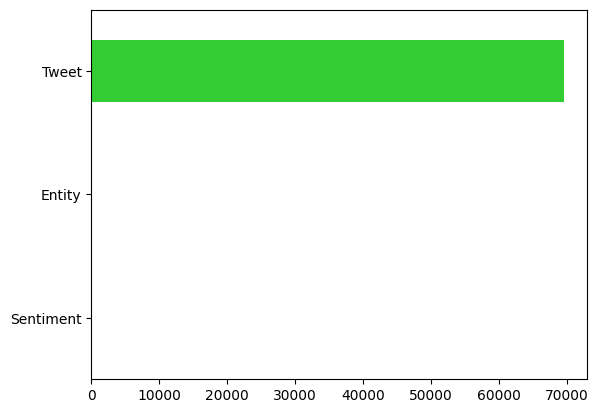

In [10]:
df.nunique().sort_values().plot(kind='barh',color='limegreen')

In [11]:
df.duplicated().sum()

3621

#### **Remove Duplicates & Nulls**

In [12]:
#Clean the dataset
df_clean = df.drop_duplicates()
df_cleaned = df_clean.dropna()


## **Data Analysis**

Let's look at the distribution amongs the sentiments in the dataframe. A good tool of choice for this would be a pie chart.

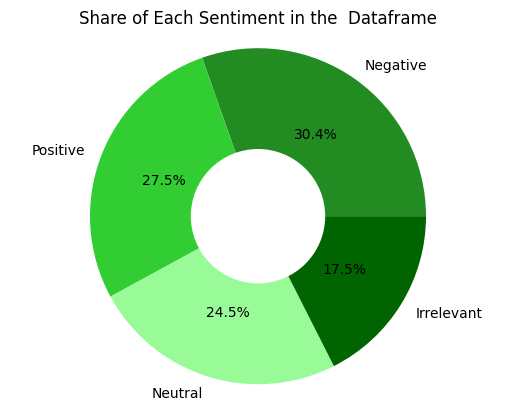

In [13]:
my_labels = {'Negative':'Negative','Positive':'Positive','Neutral':'Neutral','Irrelevant':'Irrelevant'}
#my_colors = {'navy', 'royalblue', 'lightsteelblue', 'lavender'}
my_colors = {'darkgreen', 'forestgreen', 'limegreen', 'palegreen'}

count = df_cleaned.Sentiment.map(my_labels).value_counts()

plt.pie(count, labels=count.index, autopct='%1.1f%%',colors=my_colors)
# draw circle
centre_circle = plt.Circle((0, 0), 0.40, fc='white')
fig = plt.gcf()
# Adding Circle in Pie chart
fig.gca().add_artist(centre_circle)
plt.axis('equal')
plt.title('Share of Each Sentiment in the  Dataframe')
plt.show()


In [14]:
count = df_cleaned.pivot_table(index='Entity',columns='Sentiment',aggfunc='size',fill_value=0)
count = pd.DataFrame(count)

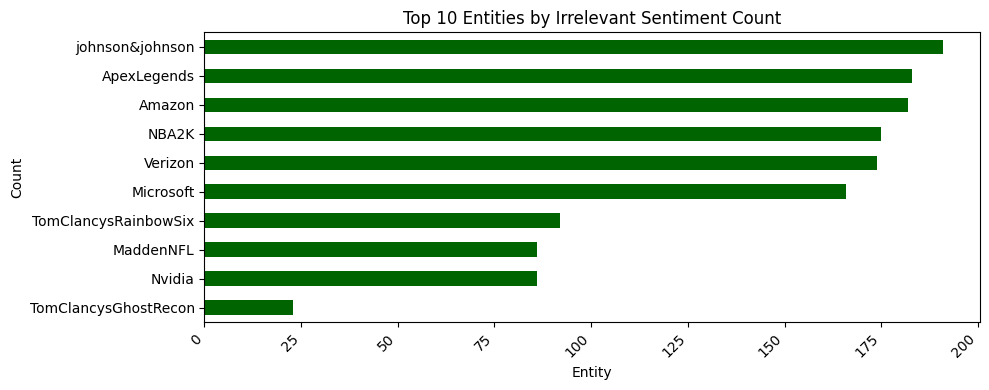

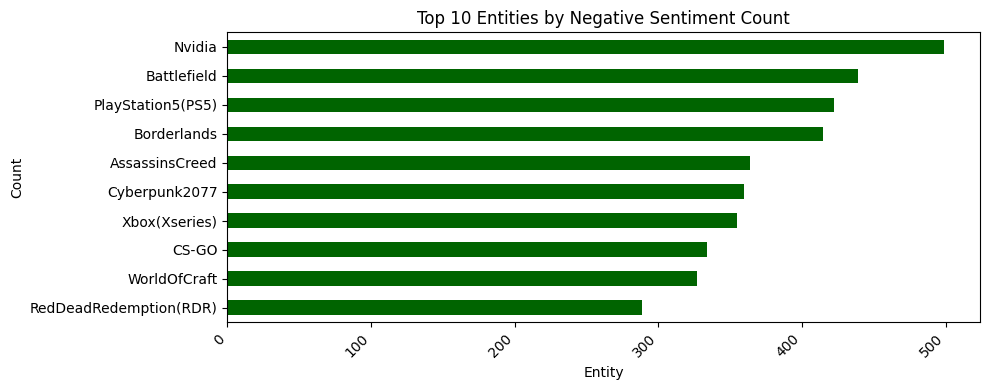

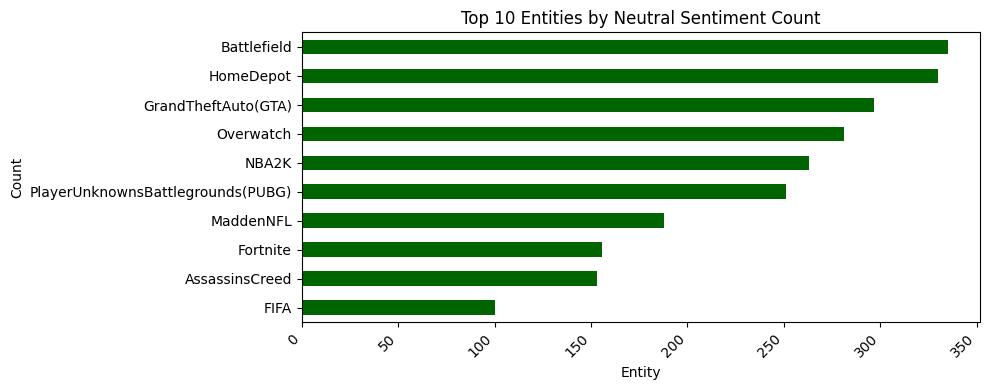

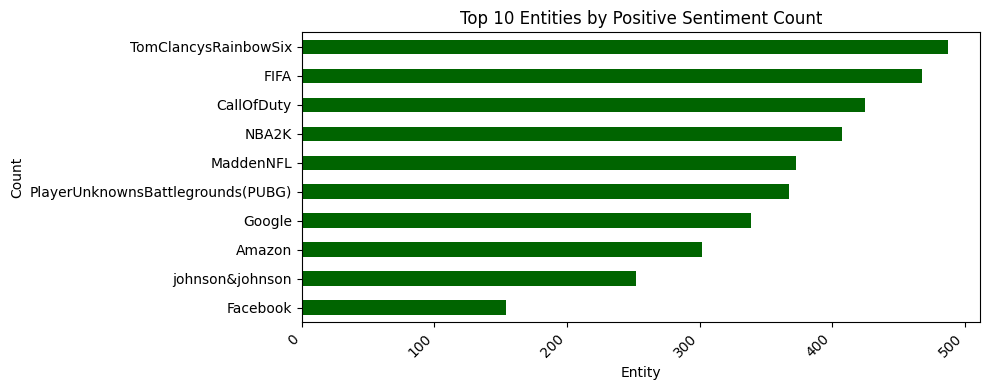

In [15]:
cols = ['Irrelevant', 'Negative', 'Neutral', 'Positive']
for col in cols:
    count_plt = count[col].sort_values(ascending=True).head(10)
    plt.figure(figsize=(10,4))
    count_plt.plot(kind='barh',color='darkgreen')
    plt.title(f'Top 10 Entities by {col} Sentiment Count')
    plt.xlabel('Entity')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    #plt.axis('off')
    plt.tight_layout()
    plt.show()

In [16]:
cols = ['Irrelevant', 'Negative', 'Neutral', 'Positive']

for sentiment in count.columns:
    min_ent = count[sentiment].idxmin()
    max_ent = count[sentiment].idxmax()
    min_val = count[sentiment].min()
    max_val = count[sentiment].max()
    print(f"Sentiment {sentiment}:")
    print("------------------------------------------")
    print(f"   Max Value '{max_val}' for Entity is: '{max_ent}' ")
    print(f"   Min Value '{min_val}' for Entity is: '{min_ent}'\n ")


Sentiment Irrelevant:
------------------------------------------
   Max Value '906' for Entity is: 'Battlefield' 
   Min Value '23' for Entity is: 'TomClancysGhostRecon'
 
Sentiment Negative:
------------------------------------------
   Max Value '1647' for Entity is: 'MaddenNFL' 
   Min Value '289' for Entity is: 'RedDeadRedemption(RDR)'
 
Sentiment Neutral:
------------------------------------------
   Max Value '1165' for Entity is: 'Amazon' 
   Min Value '100' for Entity is: 'FIFA'
 
Sentiment Positive:
------------------------------------------
   Max Value '1372' for Entity is: 'AssassinsCreed' 
   Min Value '154' for Entity is: 'Facebook'
 


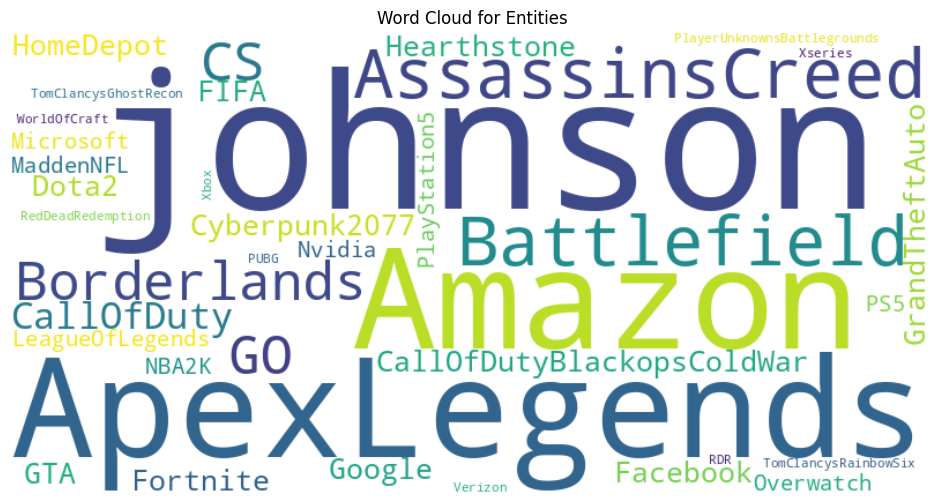

In [17]:
entity_texts = ' '.join(count.index)
word_cloud = WordCloud(width=800,height=400,background_color='white').generate(entity_texts)
#plot the Word Cloud
plt.figure(figsize=(12,6))
plt.imshow(word_cloud,interpolation='bilinear')
plt.title('Word Cloud for Entities')
plt.axis('off')
plt.show()


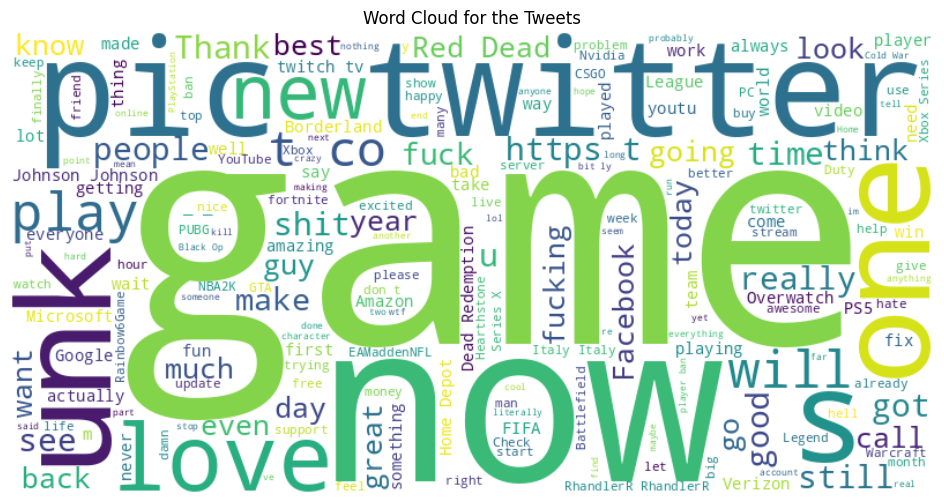

In [18]:
tweet_texts = ' '.join(df_cleaned['Tweet'])
word_cloud = WordCloud(width=800,height=400,background_color='white').generate(tweet_texts)
#plot the Word Cloud
plt.figure(figsize=(12,6))
plt.imshow(word_cloud,interpolation='bilinear')
plt.title('Word Cloud for the Tweets')
plt.axis('off')
plt.show()

## **Data Preprocessing**

In this section we will:

- Convert values to Lowercase 
- Remove HTML tags if found
- Remove Non String values
- Remove URLs
- Remove Numerical Values
- Remove Punctuations
- Tokenize the Texts (Tweets)
- Remove Stopwords
- Remove Characters and Emojis
- Vectorize Data

In [19]:
#Convert values to lower case
def normalize_text(text):
    return text.lower()

In [20]:
# Remove strings 
def filterout_non_strings(df, column):
    df = df.dropna(subset=[column])
    df[column] = df[column].astype(str)
    return df

In [21]:
# remove html tags
def remove_html(text):
    return re.sub(r'<.*?>','',text)

In [22]:
#Remove url
def remove_urls(text):
    return re.sub(r'http\S+|www\S+', '', text)

In [23]:
#remove bnumerica values
def remove_num_values(text):
    return re.sub(r'\d+', '', text)

In [24]:
#remove puncatuation
def remove_punct(text):
    return text.translate(str.maketrans('','', string.punctuation))

In [25]:
#tokenize the texts
def tokenizer_text(text):
    return word_tokenize(text)

In [26]:
#remove stopwords
def remove_stopwords(tokens):
    stopwords_ = set(stopwords.words('english'))
    return [word for word in tokens if word not in stopwords_]

In [27]:
#remove emojis
def remove_emojis(text):
    if isinstance(text, str):
        emoji = re.compile(
            "["
                u"\U0001F600-\U0001F64F"  # emoticons
                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                u"\U00002500-\U00002BEF"  # chinese char
                u"\U00002702-\U000027B0"
                u"\U00002702-\U000027B0"
                u"\U000024C2-\U0001F251"
                u"\U0001f926-\U0001f937"
                u"\U00010000-\U0010ffff"
                u"\u2640-\u2642"
                u"\u2600-\u2B55"
                u"\u200d"
                u"\u23cf"
                u"\u23e9"
                u"\u231a"
                u"\ufe0f"  # dingbats
                u"\u3030"
                "]+",
                flags=re.UNICODE
            )
        return emoji.sub(r'',text)
    else:
        return text 

In [28]:
# Remove @ and mention, replace by 
def remove_mention(text):
    at=re.compile(r'@\S+')
    return at.sub(r'',text)

In [29]:
#Vecotrization of the Dataset
def vectorize_df(text_data):
    text_strings = [" ".join(tokens) for tokens in text_data]
    tfidvectorizer = TfidfVectorizer()
    tfidvectors = tfidvectorizer.fit_transform(text_strings)
    return tfidvectors, tfidvectorizer

In [30]:
def preprocesser(df):
    df = filterout_non_strings(df, 'Tweet')
    df['Tweet'] = df['Tweet'].apply(normalize_text)
    df['Tweet'] = df['Tweet'].apply(remove_html)
    df['Tweet'] = df['Tweet'].apply(remove_urls)
    df['Tweet'] = df['Tweet'].apply(remove_num_values)
    df['Tweet'] = df['Tweet'].apply(remove_punct)
    df['Tweet'] = df['Tweet'].apply(tokenizer_text)
    df['Tweet'] = df['Tweet'].apply(remove_stopwords)
    #df['Tweet'] = df['Tweet'].apply(remove_mention)
    df['Tweet'] = df['Tweet'].apply(remove_emojis)

    return df


preprocessed_df = preprocesser(df_cleaned)
preprocessed_df

,Entity,Sentiment,Tweet
0,Borderlands,Positive,"[coming, borders, kill]"
1,Borderlands,Positive,"[im, getting, borderlands, kill]"
2,Borderlands,Positive,"[im, coming, borderlands, murder]"
3,Borderlands,Positive,"[im, getting, borderlands, murder]"
4,Borderlands,Positive,"[im, getting, borderlands, murder]"
...,...,...,...
74676,Nvidia,Positive,"[realized, windows, partition, mac, like, year..."
74677,Nvidia,Positive,"[realized, mac, window, partition, years, behi..."
74678,Nvidia,Positive,"[realized, windows, partition, mac, years, beh..."
74679,Nvidia,Positive,"[realized, windows, partition, mac, like, year..."


We will need to join the values a single statment (Tweet)

In [31]:
preprocessed_df['Tweet'] = preprocessed_df['Tweet'].apply(lambda x: ' '.join(x))

preprocessed_df.head()

,Entity,Sentiment,Tweet
0,Borderlands,Positive,coming borders kill
1,Borderlands,Positive,im getting borderlands kill
2,Borderlands,Positive,im coming borderlands murder
3,Borderlands,Positive,im getting borderlands murder
4,Borderlands,Positive,im getting borderlands murder


## **Build Model**

### Label Encoding

In [32]:
preprocessed_df_xgb = preprocessed_df.copy()

In [33]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
preprocessed_df_xgb['Sentiment'] = label_encoder.fit_transform(preprocessed_df_xgb['Sentiment'])

### Train Test Split

In [34]:
#Feature Variable
X = preprocessed_df_xgb['Tweet']
#Target Variable
y = preprocessed_df_xgb['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (56765,)
Shape of X_test: (14192,)
Shape of y_train: (56765,)
Shape of y_test: (14192,)


### Vectorize Variables

In [35]:
# create an instance for vectorizer
tfd_vectorizer = TfidfVectorizer()

#Fit transfrom the Feature variables
X_train_vect = tfd_vectorizer.fit_transform(X_train)
X_test_vect = tfd_vectorizer.transform(X_test)

## Experiment with Different Models

#### **LGBM**

In [36]:
X_train_vect, X_train_val, y_train, y_val = train_test_split(X_train_vect, y_train, test_size=0.2, random_state=42)

In [37]:
from lightgbm import LGBMClassifier
from lightgbm import early_stopping, log_evaluation

# create ab instance of the class with the parameters
lgb_model = LGBMClassifier(
    objective='multiclass',
    num_class=len(np.unique(y)),
    n_estimators=1000,
    learning_rate=0.1,
    subsample=0.8,
    max_depth=6,
    colsample_bytree=0.8,
    random_state=42,
    verbosity=-1
)

In [38]:
lgb_model.fit(
        X_train_vect, y_train
    )

LGBMClassifier(colsample_bytree=0.8, max_depth=6, n_estimators=1000,
               num_class=4, objective='multiclass', random_state=42,
               subsample=0.8, verbosity=-1)

In [39]:
y_pred = lgb_model.predict(X_test_vect)

In [40]:
print("\nClassification Report on Training Data:")
print(classification_report(y_test, y_pred))


Classification Report on Training Data:
              precision    recall  f1-score   support

           0       0.69      0.53      0.60      2511
           1       0.74      0.78      0.76      4296
           2       0.63      0.67      0.65      3498
           3       0.70      0.72      0.71      3887

    accuracy                           0.69     14192
   macro avg       0.69      0.68      0.68     14192
weighted avg       0.69      0.69      0.69     14192



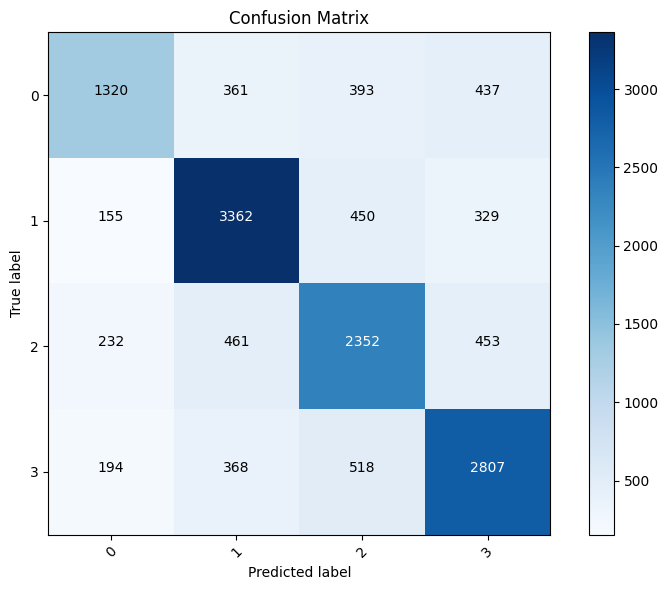

In [41]:
## Seabonr is not working on my environment. So I'll have to use matplotlib to plot the confusion matrix/ Heatmap
cm = confusion_matrix(y_test, y_pred)

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Add text annotations
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Get unique class labels
classes = np.unique(np.concatenate((y_test, y_pred)))

# Plot the confusion matrix
plot_confusion_matrix(cm, classes=classes)
plt.show()

In [42]:
print(X_train_vect.shape)
print(X_test_vect.shape)

(45412, 34536)
(14192, 34536)


### **Support Vector Machines**

In [43]:
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler(with_mean=False)

X_train_scaled = standard_scaler.fit_transform(X_train_vect) 
X_test_scaled = standard_scaler.transform(X_test_vect) 

In [44]:
from sklearn.svm import LinearSVC
from sklearn.inspection import DecisionBoundaryDisplay

svm = LinearSVC(class_weight='balanced',dual=False)
svm.fit(X_train_vect, y_train)

LinearSVC(class_weight='balanced', dual=False)

In [45]:
# predictions
y_predict_svm = svm.predict(X_test_vect)

# performance report
print("\nClassification Report on Training Data:")
print(classification_report(y_test, y_predict_svm))


Classification Report on Training Data:
              precision    recall  f1-score   support

           0       0.84      0.79      0.81      2511
           1       0.86      0.86      0.86      4296
           2       0.80      0.82      0.81      3498
           3       0.83      0.84      0.84      3887

    accuracy                           0.83     14192
   macro avg       0.83      0.83      0.83     14192
weighted avg       0.83      0.83      0.83     14192



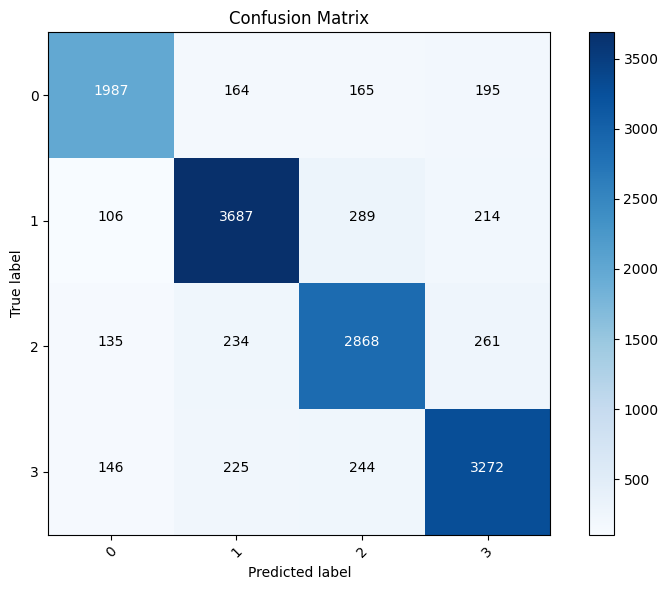

In [46]:
cm = confusion_matrix(y_test, y_predict_svm)

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Add text annotations
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Get unique class labels
classes = np.unique(np.concatenate((y_test, y_predict_svm)))

# Plot the confusion matrix
plot_confusion_matrix(cm, classes=classes)
plt.show()

#### **Cross Validation - LSVC**

In [47]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'C': [0.1, 1, 10], 
    'loss': ['hinge', 'squared_hinge'],  
    'penalty': ['l2'],  
    'dual': [True, False] 
}


grid_search = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=1
)

grid_search.fit(X_train_vect, y_train)

GridSearchCV(cv=5, estimator=LinearSVC(class_weight='balanced', dual=False),
             n_jobs=1,
             param_grid={'C': [0.1, 1, 10], 'dual': [True, False],
                         'loss': ['hinge', 'squared_hinge'],
                         'penalty': ['l2']},
             scoring='accuracy')

In [48]:
# Print best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

Best Parameters: {'C': 10, 'dual': True, 'loss': 'squared_hinge', 'penalty': 'l2'}
Best Cross-Validation Accuracy: 0.8192989373999158


In [49]:
# Get the best model
best_model = grid_search.best_estimator_

# Predict on test data
y_pred_bestmodel = best_model.predict(X_test_vect)

# Print classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_bestmodel))

              precision    recall  f1-score   support

           0       0.84      0.79      0.82      2511
           1       0.86      0.85      0.86      4296
           2       0.86      0.81      0.83      3498
           3       0.79      0.87      0.83      3887

    accuracy                           0.84     14192
   macro avg       0.84      0.83      0.83     14192
weighted avg       0.84      0.84      0.84     14192



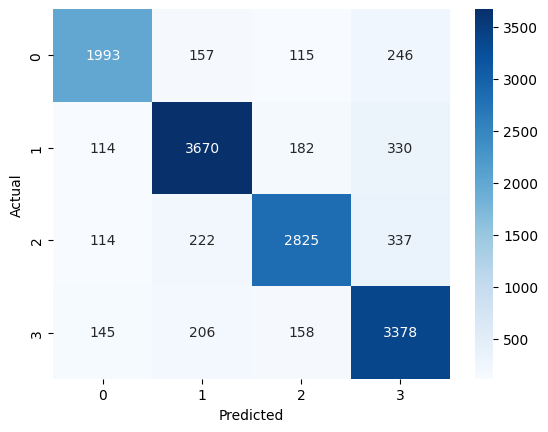

In [50]:
import seaborn as sns
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_bestmodel)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### **Random Forest Classifier**

In [51]:
# Train Random Forest classifier
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train_vect, y_train)

RandomForestClassifier(random_state=42)

In [52]:
from sklearn.model_selection import cross_val_score

#perform cross validation for 5 folds
cv_scores = cross_val_score(rfc, X_train_vect, y_train, cv=5)

print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())
print("Standard deviation of cross-validation scores:", cv_scores.std())

Cross-validation scores: [0.86249037 0.86072883 0.86324598 0.866329   0.87018278]
Mean cross-validation score: 0.8645953926623935
Standard deviation of cross-validation scores: 0.003329462773655678


In [53]:
# Let's look at the model performance on predicting for the validation set
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(rfc, X_train_vect, y_train, cv=5)
print("\nClassification Report on Training Data:")
print(classification_report(y_train, y_train_pred))
      


Classification Report on Training Data:
              precision    recall  f1-score   support

           0       0.94      0.77      0.85      7969
           1       0.88      0.90      0.89     13784
           2       0.88      0.84      0.86     11181
           3       0.80      0.91      0.85     12478

    accuracy                           0.86     45412
   macro avg       0.88      0.85      0.86     45412
weighted avg       0.87      0.86      0.86     45412



### **Prediction - Random Forest Classifier**

In [54]:
# Predict on the test set
y_test_pred = rfc.predict(X_test_vect)
  
# Print evaluation metrics
print("\nClassification Report on Test Data:")
print(classification_report(y_test, y_test_pred))

print("Confusion Matrix on Test Data:")
print(confusion_matrix(y_test, y_test_pred))

# Calculate accuracy
accuracy = rfc.score(X_test_vect, y_test)
print(f"Test Accuracy: {accuracy:.4f}")


Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.94      0.80      0.87      2511
           1       0.89      0.92      0.90      4296
           2       0.92      0.86      0.89      3498
           3       0.83      0.92      0.87      3887

    accuracy                           0.89     14192
   macro avg       0.89      0.88      0.88     14192
weighted avg       0.89      0.89      0.89     14192

Confusion Matrix on Test Data:
[[2021  176   81  233]
 [  29 3942   93  232]
 [  41  181 3008  268]
 [  53  145   98 3591]]
Test Accuracy: 0.8851


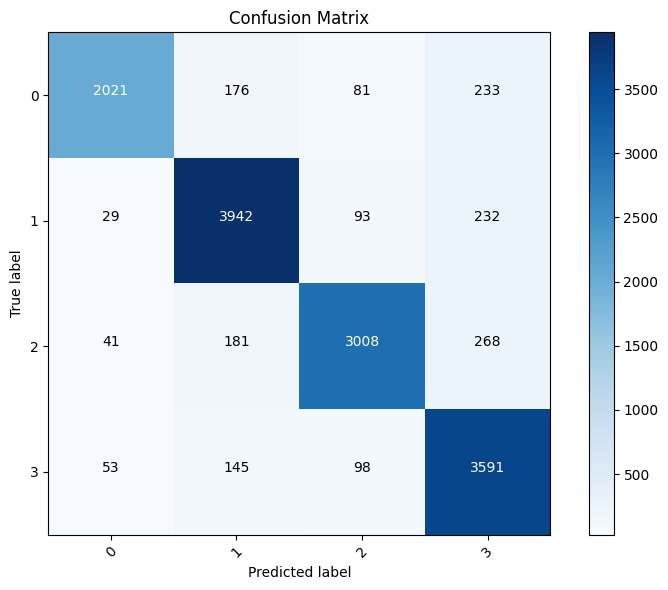

In [55]:
## Seabonr is not working on my environment. So I'll have to use matplotlib to plot the confusion matrix/ Heatmap
cm = confusion_matrix(y_test, y_test_pred)

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Add text annotations
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Get unique class labels
classes = np.unique(np.concatenate((y_test, y_test_pred)))

# Plot the confusion matrix
plot_confusion_matrix(cm, classes=classes)
plt.show()

Of all the models tried Random Forest seems to outperform the others. However, it's computational wise it's too intense and time taking. Thus, I would not recommend it for training.

## **Save Model**

In [56]:
import joblib
joblib.dump(rfc,'rfc_model.pkl')

['rfc_model.pkl']

In [67]:
# Save the label encoder for later use
joblib.dump(label_encoder, 'label_encoder.pkl')

['label_encoder.pkl']

In [68]:
label_encoder = joblib.load('label_encoder.pkl')

label_mapping = {i: label for i, label in enumerate(label_encoder.classes_)}

### **Testing Model** 

In [78]:
## Load model first
Tweet_Sentiment_Analyzer = joblib.load('rfc_model.pkl')

Sentiment_faces = {
    'Positive': '😄',
    'Negative': '😞',
    'Neutral': '😐',
    'Irrelevant': '🤷‍♂️'
        }

# Sample tweets
sample_tweets = [
    "I just finished playing Borderlands and it was absolutely amazing! Can't wait for the next one!",
    "I'm really disappointed with the latest Borderlands update. It ruined the game for me.",
    "Haven't played Borderlands in a while. Need to catch up on the latest updates.",
    "Just saw a funny cat video while searching for Borderlands gameplay. Cats always cheer me up!",
    "Just finished watching the new Marvel movie and it was out of this world! Can't wait for the next one!",
    "I'm really disappointed with the latest Marvel movie. It ruined the whole vibe for me.",
    "I am so annoyed to find the person who did this. He is in a world of trouble!",
    "Just saw a hilarious dog video while looking for Marvel movie reviews. Dogs always make my day!"
        ]


In [79]:
# Process the sample tweets
sample_tweets_vect = tfd_vectorizer.transform(sample_tweets)

#Predict the tweets sentiment
predictions = Tweet_Sentiment_Analyzer.predict(sample_tweets_vect)

predictions_str = [label_mapping[pred] for pred in predictions]

for tweet, prediction in zip(sample_tweets, predictions_str):
    sentiment = prediction
    emoji = Sentiment_faces[sentiment]
    print('Tweet:',tweet)
    print('Sentiment:',sentiment)
    print('Emoji:', emoji)
    print('----------------------------')

Tweet: I just finished playing Borderlands and it was absolutely amazing! Can't wait for the next one!
Sentiment: Positive
Emoji: 😄
----------------------------
Tweet: I'm really disappointed with the latest Borderlands update. It ruined the game for me.
Sentiment: Negative
Emoji: 😞
----------------------------
Tweet: Haven't played Borderlands in a while. Need to catch up on the latest updates.
Sentiment: Neutral
Emoji: 😐
----------------------------
Tweet: Just saw a funny cat video while searching for Borderlands gameplay. Cats always cheer me up!
Sentiment: Neutral
Emoji: 😐
----------------------------
Tweet: Just finished watching the new Marvel movie and it was out of this world! Can't wait for the next one!
Sentiment: Neutral
Emoji: 😐
----------------------------
Tweet: I'm really disappointed with the latest Marvel movie. It ruined the whole vibe for me.
Sentiment: Neutral
Emoji: 😐
----------------------------
Tweet: I am so annoyed to find the person who did this. He is in a w